In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [51]:
os.listdir('/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')

base = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
train_path = base + 'train'
test_path = base + 'valid'

In [52]:
ds_train_ = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[96, 96],
    interpolation='nearest',
    batch_size=32,
    shuffle=True,
)

ds_test_ = image_dataset_from_directory(
    test_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[96, 96],
    interpolation='nearest',
    batch_size=32,
    shuffle=False,
)

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [53]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_test = (
    ds_test_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


In [29]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
                  # give the input dimensions in the first layer
                  # [height, width, color channels(RGB)]
                  input_shape=[96, 96, 3]),
    layers.MaxPool2D(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
#     layers.Dense(units=6, activation="relu"),
    layers.Dense(units=38, activation="softmax"),
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 38)             │       700,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 795,238 (3.03 MB)

 Trainable params: 795,238 (3.03 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               verbose=0, 
                               mode='min', 
                               baseline=None, 
                               restore_best_weights=False)

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.3969 - loss: 2.1945 - val_accuracy: 0.7921 - val_loss: 0.6731
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8317 - loss: 0.5514 - val_accuracy: 0.8660 - val_loss: 0.4408
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8984 - loss: 0.3279 - val_accuracy: 0.8940 - val_loss: 0.3560
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9200 - loss: 0.2610 - val_accuracy: 0.8880 - val_loss: 0.4244
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9366 - loss: 0.2120 - val_accuracy: 0.8144 - val_loss: 0.9802
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9144 - loss: 0.3089 - val_accuracy: 0.8729 - val_loss: 0.5794
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9535 - loss: 0.1540 - val_accuracy: 0.8391 - val_loss: 1.0646
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9297 - loss: 0

In [38]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications import Xception,VGG19 , EfficientNetB0, MobileNetV2

pretrained = Xception(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')

model = keras.Sequential([

    # First Convolutional Block
    pretrained,
#     layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
#                   # give the input dimensions in the first layer
#                   # [height, width, color channels(RGB)]
#                   input_shape=[96, 96, 3]),
#     layers.MaxPool2D(),

    # Second Convolutional Block
#     layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
#     layers.MaxPool2D(),

    # Third Convolutional Block
#     layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
#     layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
#     layers.Dense(units=6, activation="relu"),
    layers.Dense(units=38, activation="softmax"),
])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 217s 79ms/step - accuracy: 0.7710 - loss: 0.8519 - val_accuracy: 0.9519 - val_loss: 0.1780
Epoch 2/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 0.9813 - loss: 0.0586 - val_accuracy: 0.9822 - val_loss: 0.0639
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 146s 66ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9854 - val_loss: 0.0571
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.9866 - val_loss: 0.0545
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 147s 67ms/step - accuracy: 0.9960 - loss: 0.0124 - val_accuracy: 0.9887 - val_loss: 0.0433
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 0.9982 - loss: 0.0049 - val_accuracy: 0.9898 - val_loss: 0.0426
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9909 - val_loss: 0.0435
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 

<Axes: >

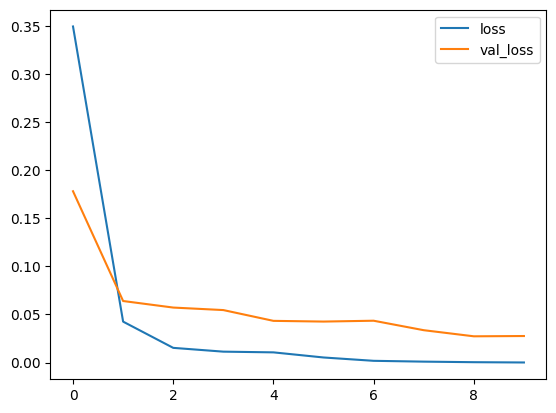

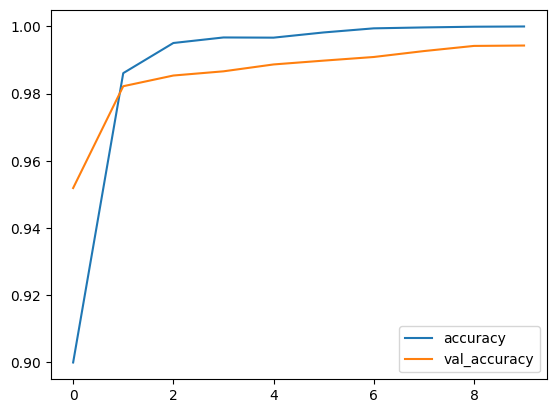

In [41]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [42]:
model.save('Xception_model_bangkit.h5')

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.applications import Xception,VGG19 , EfficientNetB0, MobileNetV2

pretrained = Xception(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')

model = keras.Sequential([

    # First Convolutional Block
    pretrained,
#     layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same',
#                   # give the input dimensions in the first layer
#                   # [height, width, color channels(RGB)]
#                   input_shape=[96, 96, 3]),
#     layers.MaxPool2D(),

    # Second Convolutional Block
#     layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
#     layers.MaxPool2D(),

    # Third Convolutional Block
#     layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
#     layers.MaxPool2D(),

    # Classifier Head
    layers.Flatten(),
#     layers.Dense(units=6, activation="relu"),
    layers.Dense(units=38, activation="sigmoid"),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [57]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 250s 93ms/step - accuracy: 0.7761 - loss: 0.8431 - val_accuracy: 0.9685 - val_loss: 0.1161
Epoch 2/10
   2/2197 ━━━━━━━━━━━━━━━━━━━━ 2:24 66ms/step - accuracy: 0.9453 - loss: 0.1272

W0000 00:00:1717751627.906849     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.9819 - loss: 0.0554 - val_accuracy: 0.9743 - val_loss: 0.1121
Epoch 3/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.9913 - loss: 0.0239 - val_accuracy: 0.9818 - val_loss: 0.0650
Epoch 4/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 148s 68ms/step - accuracy: 0.9951 - loss: 0.0096 - val_accuracy: 0.9851 - val_loss: 0.0608
Epoch 5/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 149s 68ms/step - accuracy: 0.9949 - loss: 0.0071 - val_accuracy: 0.9875 - val_loss: 0.0433
Epoch 6/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 150s 68ms/step - accuracy: 0.9961 - loss: 0.0046 - val_accuracy: 0.9892 - val_loss: 0.0314
Epoch 7/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 148s 67ms/step - accuracy: 0.9970 - loss: 0.0013 - val_accuracy: 0.9908 - val_loss: 0.0264
Epoch 8/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 148s 67ms/step - accuracy: 0.9976 - loss: 2.0668e-04 - val_accuracy: 0.9921 - val_loss: 0.0234
Epoch 9/10
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 148s 67ms/step - accuracy: 0.9978 

# Cara prediksi multilabel

In [92]:
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications import xception


list_labels = ds_train_.class_names

def predict(model, filename):
    img_width, img_height = 96, 96
    img = image.load_img(filename, target_size = (img_width, img_height, 3))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = xception.preprocess_input(img)
    return model.predict(img)


def predict_class(model, filename):
    prob_predict = predict(model, filename)[0]
    over_thr = np.where(prob_predict > 0.5)[0]
    results = {
        list_labels[x] : prob_predict[x] for x in over_thr
    }
    results = dict(sorted(results.items(), key = lambda x: x[1]))
    result = pd.DataFrame({'probability' : results.values()})
    result.index = results.keys()
    return result.sort_values('probability', ascending = False)

In [93]:
predict_class(model, '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Strawberry___Leaf_scorch/01647a51-6ee5-4686-8f60-26ebed68fe21___RS_L.Scorch 0130.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,probability
Strawberry___Leaf_scorch,1.000000
Tomato___Septoria_leaf_spot,0.999966
Tomato___Early_blight,0.999488
Grape___Black_rot,0.999137
Corn_(maize)___Common_rust_,0.999088
Apple___Black_rot,0.997928
Grape___Esca_(Black_Measles),0.965289
Grape___Leaf_blight_(Isariopsis_Leaf_Spot),0.964222
Potato___healthy,0.935553
Tomato___Tomato_mosaic_virus,0.918699


In [94]:
model.save('Xception_multilabel_bangkit.h5')

In [10]:
for x, y in ds_train_:
    break

In [12]:
os.listdir('/kaggle/input/new-plant-diseases-dataset/test/test')

['TomatoEarlyBlight6.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus6.JPG',
 'PotatoHealthy2.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'PotatoEarlyBlight2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoEarlyBlight3.JPG',
 'CornCommonRust2.JPG',
 'AppleScab3.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoHealthy2.JPG',
 'CornCommonRust1.JPG',
 'PotatoEarlyBlight4.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'CornCommonRust3.JPG',
 'TomatoEarlyBlight4.JPG',
 'AppleCedarRust3.JPG',
 'TomatoHealthy3.JPG',
 'AppleScab1.JPG',
 'TomatoHealthy1.JPG',
 'AppleScab2.JPG',
 'AppleCedarRust1.JPG',
 'PotatoHealthy1.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'PotatoEarlyBlight1.JPG',
 'AppleCedarRust2.JPG',
 'PotatoEarlyBlight3.JPG',
 'TomatoEarlyBlight1.JPG',
 'AppleCedarRust4.JPG',
 'PotatoEarlyBlight5.JPG',
 'TomatoHealthy4.JPG']

# Cara Prediksi

## Load Model

In [48]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/jkjhkjhkhk/tensorflow2/jlkjljigff/1/Xception_model_bangkit.h5')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 3, 3, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │       700,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,561,936 (82.25 MB)

 Trainable params: 21,507,406 (82.04 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 2 (12.00 B)

## Pipeline untuk prediksi satu gambar

In [49]:
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications import xception


list_labels = ds_train_.class_names

def predict(model, filename):
    img_width, img_height = 96, 96
    img = image.load_img(filename, target_size = (img_width, img_height, 3))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = xception.preprocess_input(img)
    return list_labels[np.argmax(model.predict(img))]

## Contoh Prediksi

In [50]:
predict(model, '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Strawberry___Leaf_scorch/0361a9eb-143c-4ce2-b933-ee4a84524b27___RS_L.Scorch 1258_flipLR.JPG')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'Strawberry___Leaf_scorch'